In [1]:
# Setup: load and prepare data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Load CSV
df = pd.read_csv('smmh.csv')

# Key columns
col_gender = '2. Gender'
col_rel = '3. Relationship Status'
col_occ = '4. Occupation Status'
col_platforms = '7. What social media platforms do you commonly use?'
col_usage = '8. What is the average time you spend on social media every day?'

# Clean gender into Male/Female/Other
g = df[col_gender].astype(str).str.strip().str.lower()
df['Gender_Clean'] = np.where(g.str.contains('female'), 'Female', np.where(g.str.contains('male'), 'Male', 'Other'))

# Usage order and minutes midpoint
usage_order = [
    'Less than an Hour',
    'Between 1 and 2 hours',
    'Between 2 and 3 hours',
    'Between 3 and 4 hours',
    'Between 4 and 5 hours',
    'More than 5 hours'
]
usage_mid = {
    'Less than an Hour': 30,
    'Between 1 and 2 hours': 90,
    'Between 2 and 3 hours': 150,
    'Between 3 and 4 hours': 210,
    'Between 4 and 5 hours': 270,
    'More than 5 hours': 330
}

df[col_usage] = df[col_usage].astype(str).str.strip()
df['Usage_Category'] = pd.Categorical(df[col_usage], categories=usage_order, ordered=True)
df['Usage_Minutes'] = df[col_usage].map(usage_mid)

# Platforms split and one-hot
platforms_series = df[col_platforms].fillna('').astype(str)
platforms_list = platforms_series.apply(lambda s: [p.strip() for p in s.split(',') if p.strip()])
all_platforms = sorted({p for sub in platforms_list for p in sub})
for p in all_platforms:
    df[f'PLAT_{p}'] = platforms_list.apply(lambda lst: 1 if p in lst else 0)

plat_cols = [c for c in df.columns if c.startswith('PLAT_')]
df['Platform_Count'] = df[plat_cols].sum(axis=1).replace(0, np.nan)

print('Prepared columns: Gender_Clean, Usage_Category, Usage_Minutes, platform dummies ->', len(plat_cols))


Prepared columns: Gender_Clean, Usage_Category, Usage_Minutes, platform dummies -> 9


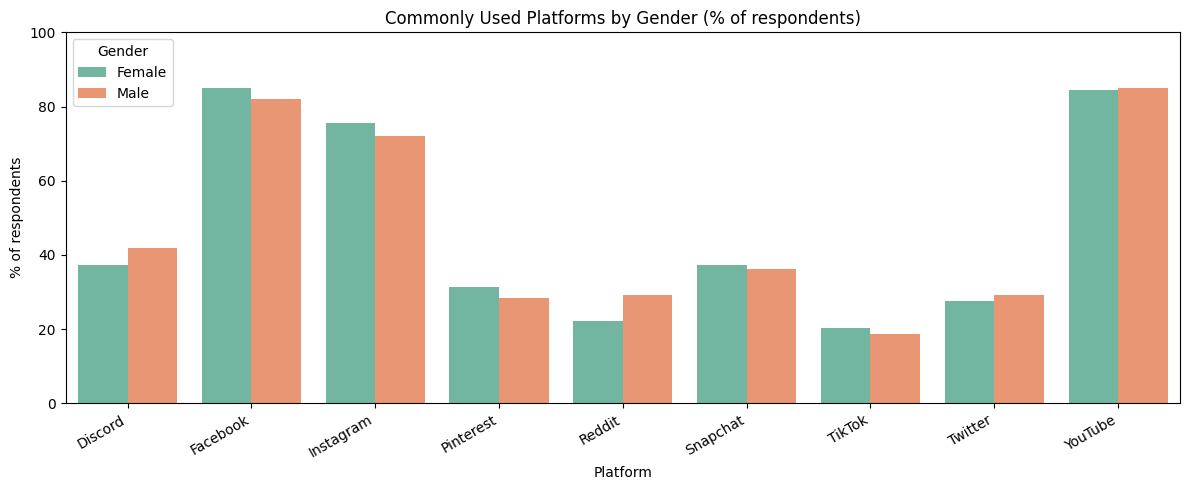

In [2]:
# 1) Commonly used platforms by respondents (Male vs Female) - Percent bars
# Compute percent of respondents selecting each platform within gender
mf_df = df[df['Gender_Clean'].isin(['Male','Female'])].copy()
plat_cols = [c for c in df.columns if c.startswith('PLAT_') and not c.endswith('_pct')]

summary = []
for pcol in plat_cols:
    platform = pcol[len('PLAT_'):]
    for gender, gdata in mf_df.groupby('Gender_Clean'):
        num = gdata[pcol].sum()
        denom = len(gdata)
        pct = 100 * num / denom if denom else np.nan
        summary.append({'Platform': platform, 'Gender': gender, 'Percent': pct})
platform_pct = pd.DataFrame(summary)

plt.figure(figsize=(12,5))
sns.barplot(data=platform_pct, x='Platform', y='Percent', hue='Gender', palette='Set2')
plt.xticks(rotation=30, ha='right')
plt.title('Commonly Used Platforms by Gender (% of respondents)')
plt.ylabel('% of respondents')
plt.xlabel('Platform')
plt.ylim(0, 100)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12980\32258609.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Usage_Category', order=order, palette='Blues')


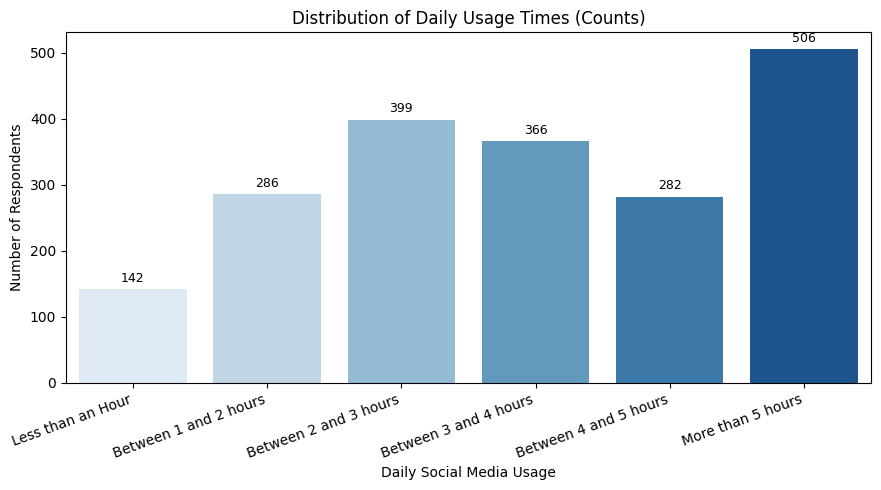

In [3]:
# 2) Distribution of Daily Social Media Usage Times with Number of Respondents
plt.figure(figsize=(9,5))
order = [
    'Less than an Hour',
    'Between 1 and 2 hours',
    'Between 2 and 3 hours',
    'Between 3 and 4 hours',
    'Between 4 and 5 hours',
    'More than 5 hours'
]
ax = sns.countplot(data=df, x='Usage_Category', order=order, palette='Blues')
plt.xticks(rotation=20, ha='right')
plt.xlabel('Daily Social Media Usage')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Daily Usage Times (Counts)')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12980\3759366221.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col_rel, order=df[col_rel].value_counts().index, palette='Set2')


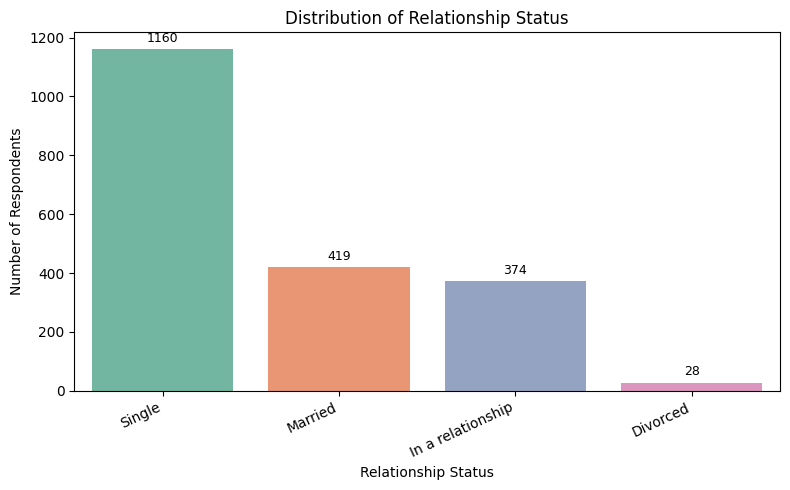

Relationship status counts:
3. Relationship Status
Single               1160
Married               419
In a relationship     374
Divorced               28
Name: count, dtype: int64

Relationship status percentages:
3. Relationship Status
Single               58.6
Married              21.2
In a relationship    18.9
Divorced              1.4
Name: count, dtype: float64


ValueError: cannot insert Gender_Clean, already exists

In [4]:
# 3) Relationship distribution and quick insights
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x=col_rel, order=df[col_rel].value_counts().index, palette='Set2')
plt.xticks(rotation=25, ha='right')
plt.xlabel('Relationship Status')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Relationship Status')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()

# Insights
counts = df[col_rel].value_counts(dropna=False)
perc = (counts / len(df) * 100).round(1)
print('Relationship status counts:')
print(counts)
print('\nRelationship status percentages:')
print(perc)

# Optional: relationship by gender (stacked %)
rel_gender = (
    df[df['Gender_Clean'].isin(['Male','Female'])]
      .groupby(['Gender_Clean', col_rel])
      .size()
      .groupby(level=0)
      .apply(lambda s: s / s.sum() * 100)
      .reset_index(name='Percent')
)
plt.figure(figsize=(9,5))
sns.barplot(data=rel_gender, x=col_rel, y='Percent', hue='Gender_Clean', palette='Pastel2')
plt.xticks(rotation=25, ha='right')
plt.ylabel('Percent within gender')
plt.title('Relationship Status by Gender (%)')
plt.tight_layout()
plt.show()
